In [1]:
# Suppression des avertissements
import warnings
warnings.filterwarnings('ignore')

# Modules de base
import numpy as np
import pandas as pd
import random

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Stats et analyses statistiques
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

# Machine Learning et modèles de régression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Divers
import joblib

# Configuration du style de visualisation des graphiques avec un style personnalisé
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")
# Configuration pour l'affichage des nombres à virgule flottante
pd.options.display.float_format = '{:.4f}'.format

In [2]:
# Chargement des modèles
model_lr = joblib.load('../00 - Annexes/models/model_lr.pkl')
model_rf = joblib.load('../00 - Annexes/models/model_rf.pkl')
model_xgb = joblib.load('../00 - Annexes/models/model_xgb.pkl')
model_ridge = joblib.load('../00 - Annexes/models/model_ridge.pkl')
model_lasso = joblib.load('../00 - Annexes/models/model_lasso.pkl')
model_dt = joblib.load('../00 - Annexes/models/model_dt.pkl')
model_sarimax = joblib.load('../00 - Annexes/models/model_sarimax.pkl')

--------------------------------------


In [3]:
# Chargement du jeu de validation scalé
df_validation_scaled = pd.read_csv("../00 - Annexes/data_prepro/donnees_validation_scaled.csv")

metrics_train = pd.read_csv('../00 - Annexes/data_prepro/metrics_train.csv')

In [4]:
# Extraire les identifiants et la cible
df_predictions = df_validation_scaled[['SKU', 'Prix']].copy()

# Préparer les features pour les modèles ML
X_validation_scaled = df_validation_scaled.drop(columns=['SKU', 'Prix', 'Timestamp']).values

# Prédictions des modèles de régression
df_predictions['Régression Linéaire'] = model_lr.predict(X_validation_scaled)
df_predictions['Random Forest']= model_rf.predict(X_validation_scaled)
df_predictions['XGBoost'] = model_xgb.predict(X_validation_scaled)
df_predictions['Ridge'] = model_ridge.predict(X_validation_scaled)
df_predictions['Lasso']= model_lasso.predict(X_validation_scaled)
df_predictions['Decision Tree']= model_dt.predict(X_validation_scaled)

# Préparer les exogènes pour SARIMAX
exog_columns = ['QuantiteVendue', 'UtiliteProduit', 'ElasticitePrix', 'Remise']
exog_validation = df_validation_scaled[exog_columns]

# Nettoyage des exogènes
exog_validation.replace([np.inf, -np.inf], np.nan, inplace=True)
exog_validation.dropna(inplace=True)

# Vérifier les dimensions des exogènes avant prédiction
if len(exog_validation) != len(df_predictions):
    raise ValueError("Mismatch between exogenous variables and target size!")

# Faire les prédictions SARIMAX
forecast = model_sarimax.get_forecast(steps=len(exog_validation), exog=exog_validation)
df_predictions['SARIMAX'] = forecast.predicted_mean.values

df_predictions


,SKU,Prix,Régression Linéaire,Random Forest,XGBoost,Ridge,Lasso,Decision Tree,SARIMAX
0,SKU1_1,422.9680,338.7249,277.6004,410.6649,338.7224,338.5506,383.5379,469.6280
1,SKU1_1,422.8309,341.4678,278.6991,410.8554,341.4654,341.2989,383.5379,469.5254
2,SKU1_1,422.4601,339.8976,280.1556,410.6649,339.8952,339.7552,383.5379,469.3917
3,SKU1_1,380.1274,323.6419,264.9739,369.2260,323.6391,323.5131,383.5379,214.1684
4,SKU1_1,423.2454,344.2766,281.1688,415.5829,344.2743,344.1041,383.5379,469.1718
...,...,...,...,...,...,...,...,...,...
27370,SKU3_8,39.8088,62.9811,39.3110,39.3466,62.9812,62.8401,36.8461,383.3610
27371,SKU3_8,40.2398,62.0276,38.9840,39.3377,62.0277,61.9123,36.8461,383.3829
27372,SKU3_8,40.1021,60.8103,39.1136,39.3377,60.8104,60.6629,36.8461,383.4197
27373,SKU3_8,39.5782,65.2320,39.3491,39.3466,65.2322,65.0881,36.8461,383.3096


In [5]:
# Calcul des métriques pour chaque modèle
metrics = {}
for model_name in ['Régression Linéaire', 'Random Forest', 'XGBoost', 
        'Ridge', 'Lasso', 'Decision Tree', 'SARIMAX']:
    mse = mean_squared_error(df_predictions['Prix'], df_predictions[model_name])
    mae = mean_absolute_error(df_predictions['Prix'], df_predictions[model_name])
    rmse = mse ** 0.5
    r2 = r2_score(df_predictions['Prix'], df_predictions[model_name])
    metrics[model_name] = {'RMSE': rmse, 'MAE': mae, 'R² Score': r2}

# Calcul des métriques pour SARIMAX
mse_sarimax = mean_squared_error(df_predictions['Prix'], df_predictions['SARIMAX'])
mae_sarimax = mean_absolute_error(df_predictions['Prix'], df_predictions['SARIMAX'])
rmse_sarimax = mse_sarimax ** 0.5

# Ajouter SARIMAX aux métriques
metrics['SARIMAX'] = {'RMSE': rmse_sarimax, 'MAE': mae_sarimax, 'R² Score': None}

# Convertir les métriques en DataFrame
metrics_val = pd.DataFrame(metrics).T.reset_index().rename(columns={'index': 'Modèle'})
metrics_val

,Modèle,RMSE,MAE,R² Score
0,Régression Linéaire,34.5928,27.7955,0.9494
1,Random Forest,65.5317,37.8404,0.8184
2,XGBoost,9.3682,4.9325,0.9963
3,Ridge,34.5936,27.7961,0.9494
4,Lasso,34.5973,27.7643,0.9494
5,Decision Tree,29.8043,14.5480,0.9624
6,SARIMAX,407.7545,322.9841,NaN


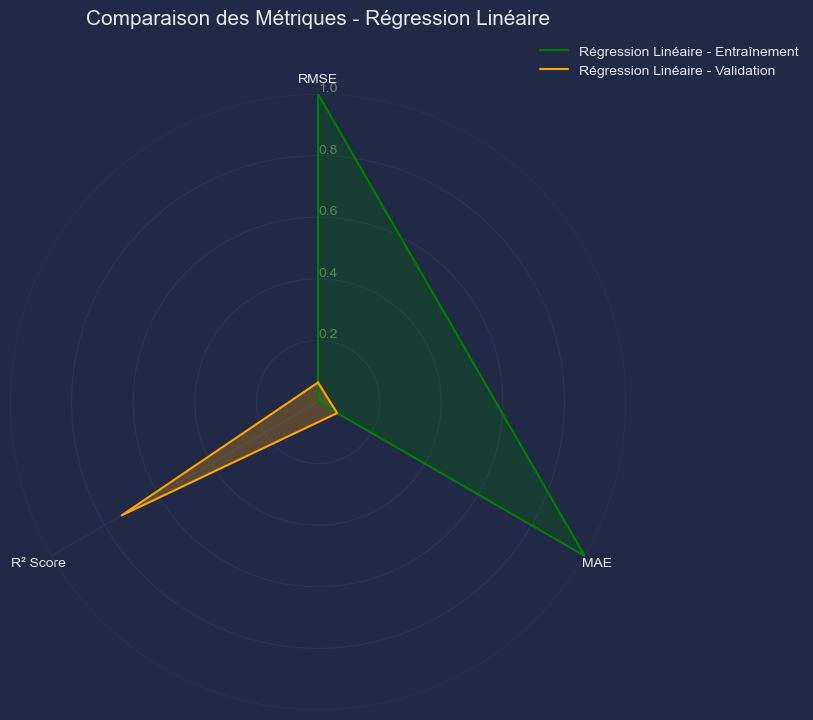

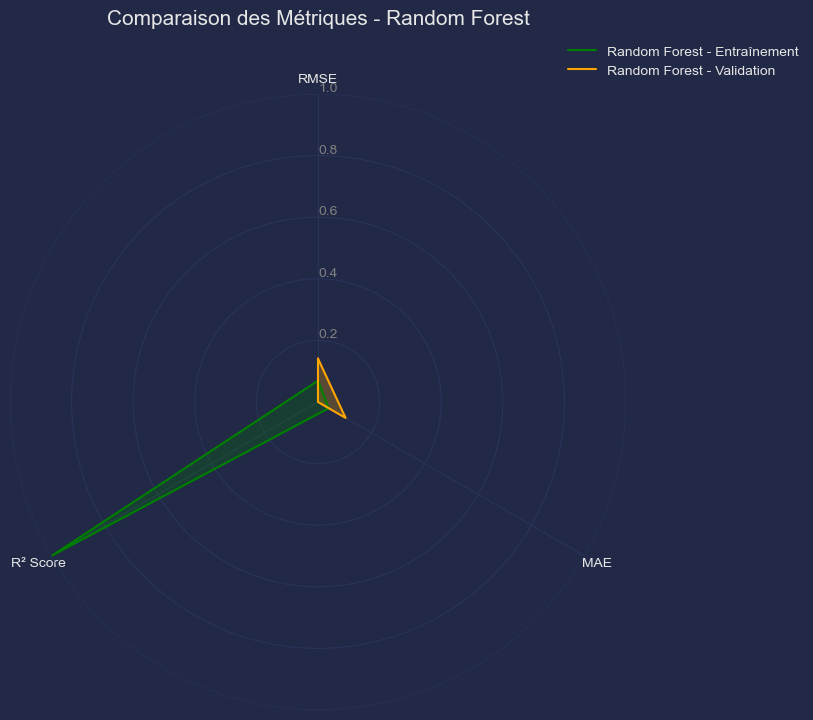

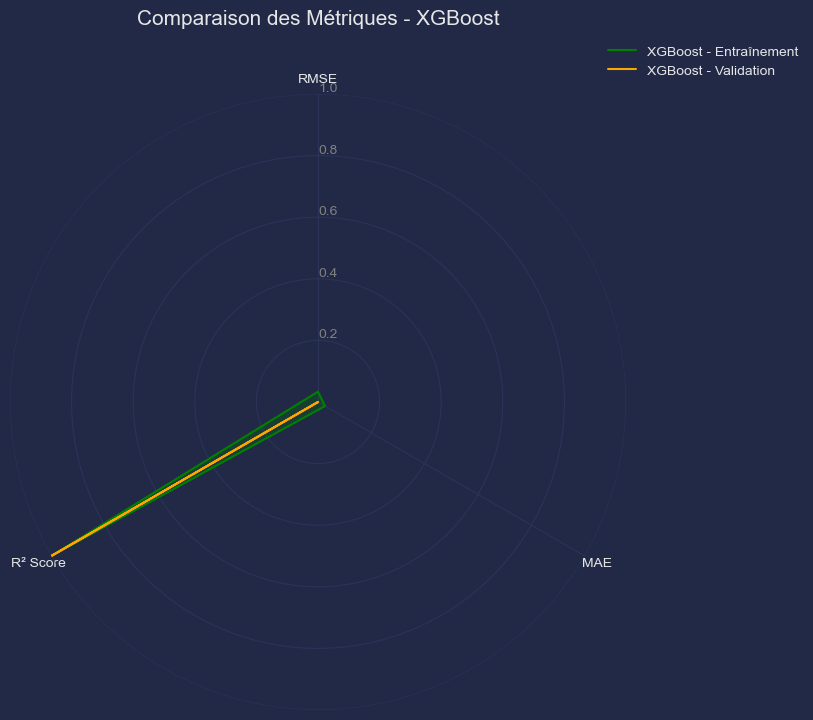

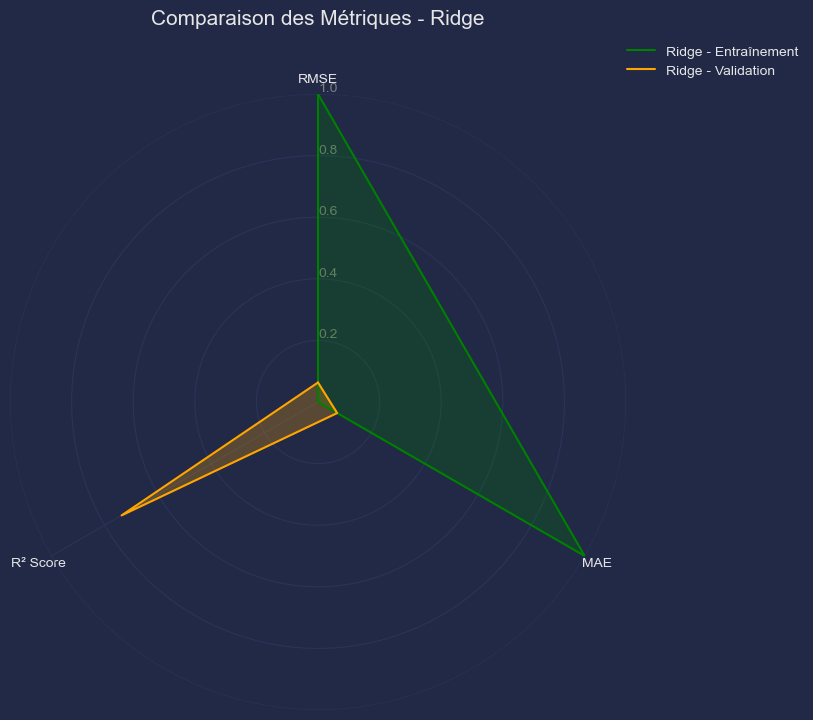

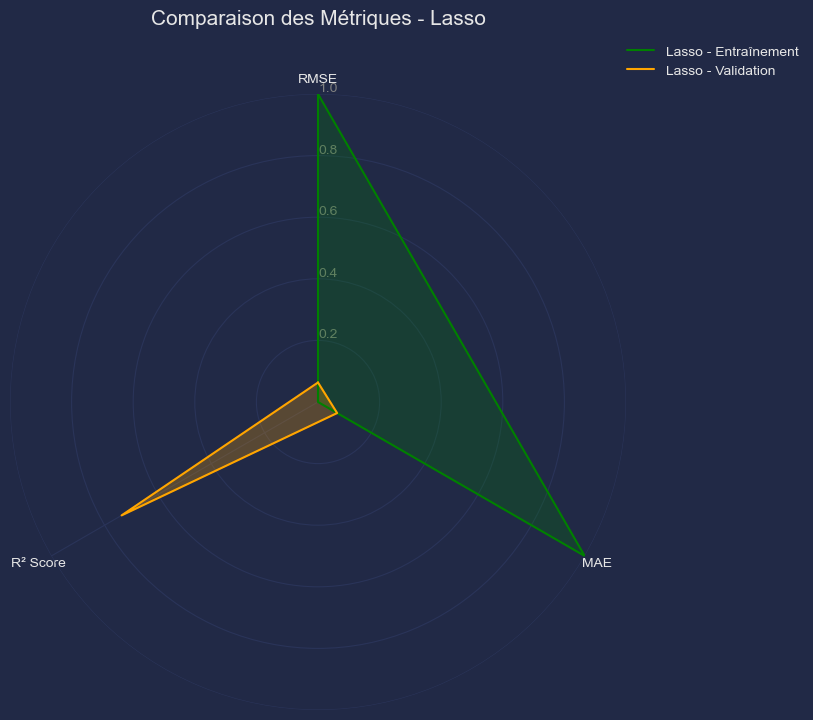

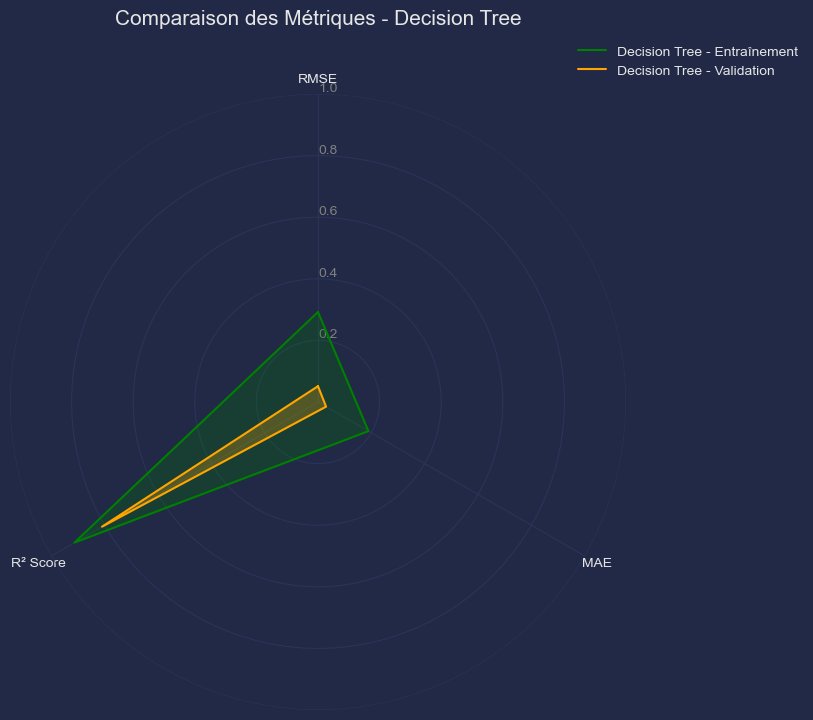

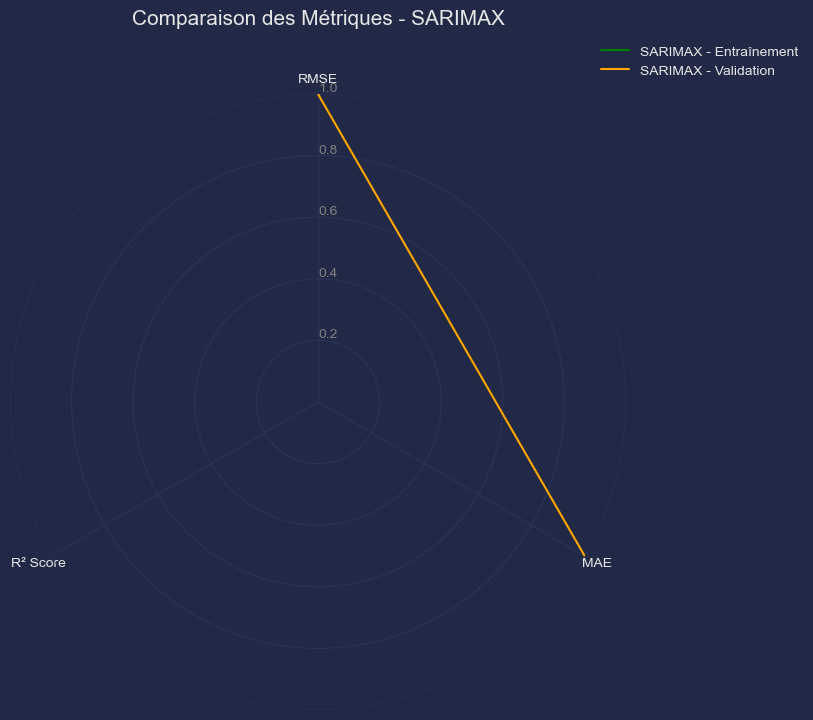

In [6]:
# Fonction pour normaliser les métriques entre 0 et 1
def normalize_metrics(metrics_df):
    metrics_normalized = metrics_df.copy()
    # Normalisation des colonnes numériques
    metrics_normalized.iloc[:, 1:] = metrics_df.iloc[:, 1:].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return metrics_normalized

# Normaliser les métriques d'entraînement et de validation
metrics_train_normalized = normalize_metrics(metrics_train)
metrics_val_normalized = normalize_metrics(metrics_val)

# Fonction pour tracer un graphique radar pour un modèle spécifique
def plot_radar(metrics_train, metrics_val, model_name):
    # Configurer les index pour aligner les métriques
    metrics_train = metrics_train.set_index("Modèle")
    metrics_val = metrics_val.set_index("Modèle")
    
    # Extraire les métriques du modèle
    train_metrics = metrics_train.loc[model_name].values
    val_metrics = metrics_val.loc[model_name].values
    
    # Définir les catégories (colonnes)
    categories = metrics_train.columns
    num_vars = len(categories)
    
    # Préparer les angles pour le radar
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Fermer le cercle
    
    # Fermer le cercle pour les données
    train_metrics = np.append(train_metrics, train_metrics[0])
    val_metrics = np.append(val_metrics, val_metrics[0])
    
    # Création du graphique radar
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Tracer les métriques d'entraînement
    ax.plot(angles, train_metrics, label=f'{model_name} - Entraînement', color='green')
    ax.fill(angles, train_metrics, alpha=0.25, color='green')
    
    # Tracer les métriques de validation
    ax.plot(angles, val_metrics, label=f'{model_name} - Validation', color='orange')
    ax.fill(angles, val_metrics, alpha=0.25, color='orange')
    
    # Configuration des labels et de l'affichage
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_rlabel_position(0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
    ax.set_ylim(0, 1)
    
    # Ajouter légende et titre
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title(f'Comparaison des Métriques - {model_name}', size=15, y=1.1)
    plt.show()

# Tracer les graphiques radar pour chaque modèle
for model_name in metrics_train_normalized['Modèle']:
    plot_radar(metrics_train_normalized, metrics_val_normalized, model_name)


-----------------------------------------

In [8]:
def get_random_sku(dataframe, skus=None):
    if skus is None:  # Si aucune SKU ou liste n'est donnée, choisir aléatoirement dans le DataFrame
        return dataframe["SKU"].sample(1, random_state=random.randint(1, 1000)).iloc[0]
    elif isinstance(skus, list):  # Si une liste est fournie, choisir aléatoirement dans la liste
        return random.choice(skus)
    return skus  # Si une seule SKU est donnée, la retourner telle quelle

# Exemple : renseigner une liste de SKUs ou laisser aléatoire
sku_list = ["SKU1_1", "SKU2_1", "SKU3_1"]  # Exemple de liste
chosen_sku = get_random_sku(df_predictions, sku_list)

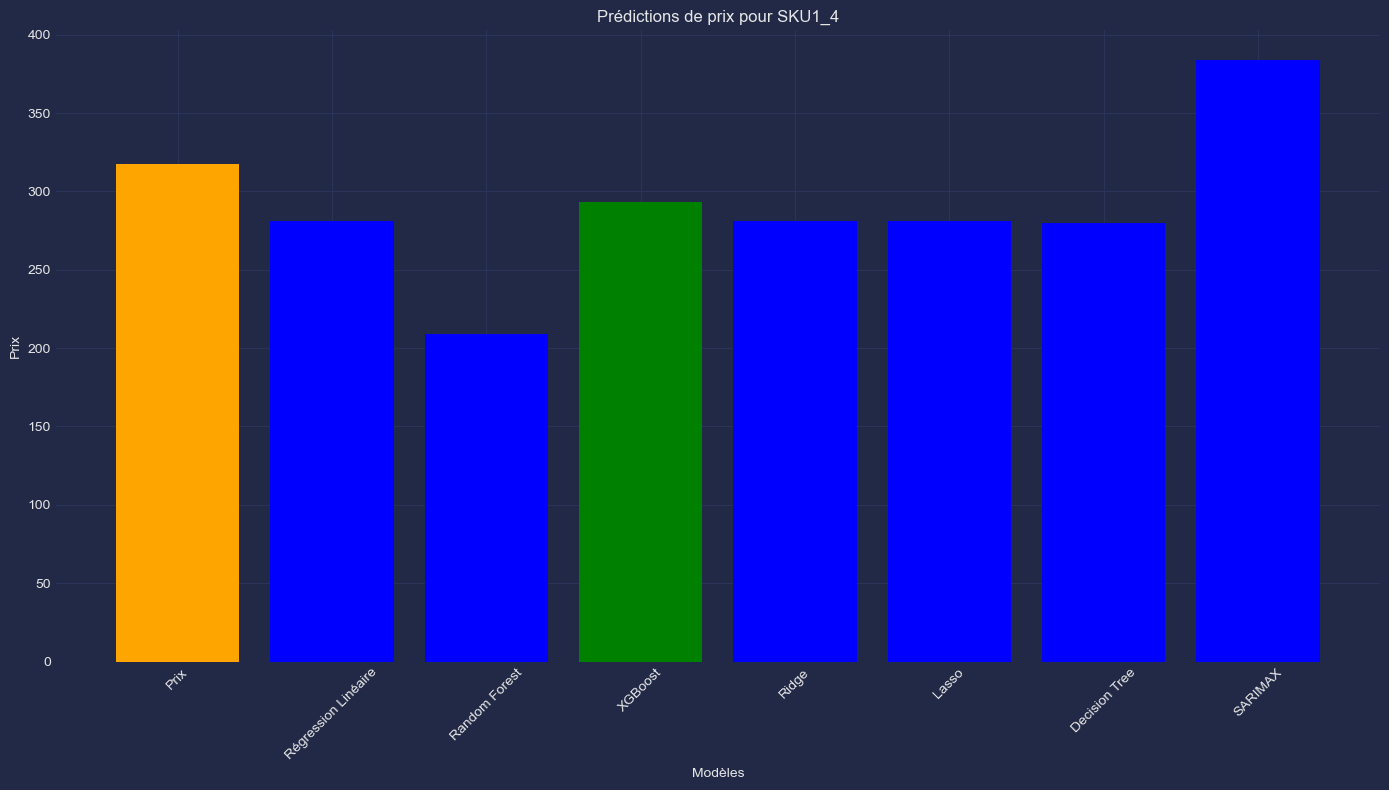

In [10]:
# Convertir toutes les colonnes pertinentes en float
cols_to_check = [col for col in df_predictions.columns if col not in ["SKU", "Timestamp"]]
df_predictions[cols_to_check] = df_predictions[cols_to_check].apply(pd.to_numeric, errors='coerce')

# Vérifiez la présence de valeurs nulles après la conversion
if df_predictions[cols_to_check].isnull().any().any():
    raise ValueError("Certaines colonnes contiennent des valeurs non numériques après la conversion.")

# Exemple : renseigner une liste de SKUs ou laisser aléatoire
sku_list = None
chosen_sku = get_random_sku(df_predictions, sku_list)


# Filtrer le DataFrame pour la SKU choisie
sku_data = df_predictions[df_predictions["SKU"] == chosen_sku]

# Choisir une ligne aléatoire pour la SKU sélectionnée
random_row = sku_data.sample(1, random_state=random.randint(1, 1000)).iloc[0]

# Recalculer les différences entre chaque modèle et le prix réel
differences = {col: abs(random_row["Prix"] - random_row[col]) for col in df_predictions.columns if col not in ["SKU", "Prix", "Timestamp"]}

# Identifier le modèle ayant la prédiction la plus proche du prix réel
best_model = min(differences, key=differences.get)

# Préparer les données pour le graphique
models_with_price = ["Prix"] + [col for col in df_predictions.columns if col not in ["SKU", "Prix", "Timestamp"]]
values_with_price = [random_row["Prix"]] + [random_row[model] for model in models_with_price if model != "Prix"]

# Définir les couleurs : orange pour "Prix" et vert pour le meilleur modèle
colors = ["orange" if model == "Prix" else ("green" if model == best_model else "blue") for model in models_with_price]

# Tracer le graphique à barres
plt.figure(figsize=(14, 8))
plt.bar(models_with_price, values_with_price, color=colors)
plt.xlabel("Modèles")
plt.ylabel("Prix")
plt.title(f"Prédictions de prix pour {chosen_sku}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()